### Get Data

https://www.kaggle.com/competitions/avazu-ctr-prediction/data

kaggle competitions download -c avazu-ctr-prediction

unzip avazu-ctr-prediction.zip

gzip -d train.gz
gzip -d test.gz

In [8]:
!cat train | wc -l; cat test | wc -l

40428968
4577465


### Imports

In [7]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import vowpalwabbit
import seaborn as sns

pd.set_option('display.max_columns', 500)

### EDA

In [2]:
df_log = pd.read_csv('train', nrows = 4000000)
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 732.4+ MB


In [3]:
df_log

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,1.736861e+19,0,14102122,1005,1,85f751fd,c4e18dd6,50e219e0,d644e4e7,2347f47a,0f2161f8,a99f214a,803991e1,e47f989b,1,0,20751,320,50,1895,0,681,100028,101
3999996,1.736862e+19,0,14102122,1005,0,85f751fd,c4e18dd6,50e219e0,f888bf4c,5b9c592b,0f2161f8,a7b0115f,9193c4b8,ab5132f6,1,0,21706,320,50,2498,3,169,100111,61
3999997,1.736892e+19,0,14102122,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,a755bd0f,e9b8d8d7,1,0,20634,320,50,2374,3,39,-1,23
3999998,1.736893e+18,0,14102122,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,b6f53ad3,ecb851b2,1,0,4687,320,50,423,2,39,100148,32


In [4]:
def get_cardinalities(df):
    s = {'name': [], 'cardinality': []}
    for column in df.columns:
        s['name'].append(column)
        s['cardinality'].append(df[column].nunique())

    return pd.DataFrame.from_dict(s).sort_values('cardinality', ascending=False).reset_index(drop=True)

pd.concat([get_cardinalities(df_log),
           get_cardinalities(df_log.head(1000000))], axis=1)

,name,cardinality,name,cardinality
0,id,4000000,id,1000000
1,device_ip,1056051,device_ip,313002
2,device_id,356977,device_id,83431
3,device_model,6061,device_model,4581
4,app_id,4114,app_id,2309
5,site_domain,3361,site_id,2075
6,site_id,2854,site_domain,2030
7,C14,776,C14,606
8,app_domain,282,C17,162
9,C17,191,C20,161


### Simulator

In [5]:
def make_crs(df, cols):
    cr = {}
    # col  = 'hour'
    for col in cols:
        # print(col)
        cr[col] = {}

        for v in df[col].unique():
            # v = int(v)
            hv = hash(v)
            # print(v)
            piece = df[df[col]==v]
            cr[col][hv] = float(piece.click.sum()/len(piece))
    return cr

crs = make_crs(df_log.sample(4000), cols=df_log.columns[2:])

In [6]:
def make_items(crs, features=None, nitems=5):
    
    if features is None:
        features = crs.keys()

    items = []

    for _ in range(nitems):
        item = {}
        item_score = 0
        for feature_name in features:
            feature_value = random.choice(list(crs[feature_name].keys()))
            item[feature_name] = feature_value
            value_click_prob = crs[feature_name][feature_value]    
            item_score += value_click_prob
        item['score'] = item_score
        item['clicked'] = False
        items.append(item)

    return items

def simulate_click(items, global_plick):    
    score_sum = sum([item['score'] for item in items])
    item_probs = [item['score']/score_sum for item in items]    
    if global_plick > random.random():
        return np.random.multinomial(n=1, pvals=item_probs).argmax()
    else:
        return -1
    
def make_vw_str(items, clicked, pclick):
    
    features = items[0].keys()
    features = list(filter(lambda s: s!='clicked', items[0].keys()))

    vw_str = ''

    for i in range(len(items)):
        if clicked == i:
            vw_str += f'0:-1:{pclick} '
            items[i]['clicked'] = True
        
        vw_str += '|Action '
        
        for feature_name in features:
            vw_str += f'{feature_name}:{items[i][feature_name]} '
        
        vw_str = vw_str[:-1]
        vw_str += '\n'
    
    vw_str = vw_str[:-1]
    
    return vw_str

def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if sum_prob > draw:
            return index, prob

In [8]:
def make_ctr_avg(ctrs, step=100):
    ctrs_avg = []
    niter = len(ctrs)
    for i in range(0, niter-step):
        # print(np.mean(ctr[i :i+step]))
        ctrs_avg.append(np.mean(ctrs[i :i+step]))
    return ctrs_avg

using no cache
Reading datafile = none
num sources = 0
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
cb_type = dr
Enabled learners: gd, scorer-identity, csoaa_ldf-rank, cb_adf, cb_explore_adf_greedy, shared_feature_merger
Input label = CB
Output pred = ACTION_PROBS
average  since         example        example        current        current  current
loss     last          counter         weight          label        predict features

finished run
number of examples = 15000
weighted example sum = 15000.000000
weighted label sum = 0.000000
average loss = -0.193680
total feature number = 2137714
using no cache
Reading datafile = none
num sources = 0
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
cb_type = dm
Enabled learners: gd, scorer-identity, csoaa_ldf-rank, cb_adf, cb_explore_adf_greedy, shared_feature_merger
Input label = CB
Output pred = ACTION_PROBS
average  since         example        example        current        current  current
loss

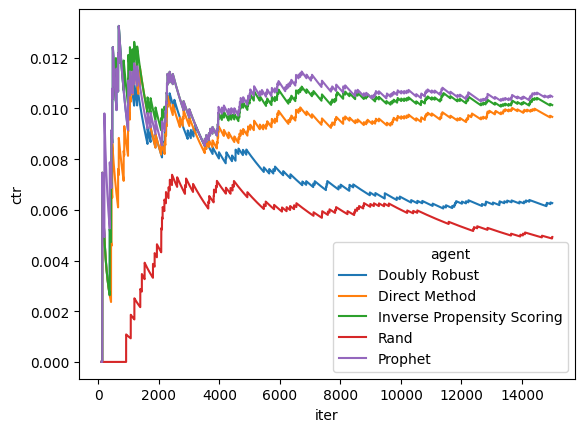

In [13]:
def learn_vw(vw, vw_str):
    vw_format = vw.parse(vw_str,
                                vowpalwabbit.LabelType.CONTEXTUAL_BANDIT)        
    vw.learn(vw_format)

def train(vw1, vw2, vw3, niter, make_items_func, global_plick, vw2_p_estimate=False):

    ctrs1 = []
    ctrs2 = []
    ctrs3 = []
    ctrs_rnd = []
    ctrs_grd = []
    
    success1 = 0
    success2 = 0
    success3 = 0
    success_rnd = 0
    success_grd = 0

    for i in range(niter):        

        items = make_items_func()


        clicked = simulate_click(items, global_plick)
        vw_str = make_vw_str(items, clicked=clicked, pclick=global_plick)
        learn_vw(vw1, vw_str)
        learn_vw(vw3, vw_str)

        if vw2_p_estimate:
            vw_str = make_vw_str(items, clicked=-1, pclick=0)
            pmf = vw2.predict(vw_str)        
            chosen_action_index, prob = sample_custom_pmf(pmf)
            vw_str = make_vw_str(items, chosen_action_index, prob)
        learn_vw(vw2, vw_str)


        items = make_items_func()
        clicked = simulate_click(items, global_plick)
        vw_str = make_vw_str(items, clicked=clicked, pclick=global_plick)

        chosen1 = np.argmax(vw1.predict(vw_str))
        chosen2 = np.argmax(vw2.predict(vw_str))
        chosen3 = np.argmax(vw3.predict(vw_str))
        chosen_rnd = np.random.randint(len(vw_str.split('\n')))
        chosen_grd = np.argmax([item['score'] for item in items])
        
        if items[chosen1]['clicked'] == True:
            success1 += 1
        if items[chosen2]['clicked'] == True:
            success2 += 1
        if items[chosen3]['clicked'] == True:
            success3 += 1
        if items[chosen_rnd]['clicked'] == True:
            success_rnd += 1
        if items[chosen_grd]['clicked'] == True:
            success_grd += 1

        ctrs1.append(success1/(i+1))
        ctrs2.append(success2/(i+1))
        ctrs3.append(success3/(i+1))
        ctrs_rnd.append(success_rnd/(i+1))
        ctrs_grd.append(success_grd/(i+1))
        
    return ctrs1, ctrs2, ctrs3,ctrs_rnd, ctrs_grd

pclick = df_log.click.sum()/len(df_log) #0.17
nitems = 30
niter = 15000
features = ['hour', 'C1', 'C18'] 
# features = crs.keys()


vw1 = vowpalwabbit.Workspace("--cb_explore_adf --epsilon 0.2 --cb_type dr")
vw2 = vowpalwabbit.Workspace("--cb_explore_adf --epsilon 0.2 --cb_type dm")
vw3 = vowpalwabbit.Workspace("--cb_explore_adf --epsilon 0.2 --cb_type ips")

make_items_func  = lambda : make_items(crs, features=features, nitems=nitems)
ctrs1, ctrs2, ctrs3, ctrs_rnd, ctrs_grd = train(vw1, vw2, vw3, niter=niter, make_items_func=make_items_func, global_plick=pclick, vw2_p_estimate=False)

plot_from_iter = 100
df_ctrs = pd.DataFrame.from_dict({'ctr': ctrs1 + ctrs2 + ctrs3 + ctrs_rnd + ctrs_grd,
                                  'iter': list(range(len(ctrs1))) + list(range(len(ctrs2))) + list(range(len(ctrs3))) + list(range(len(ctrs_rnd))) + list(range(len(ctrs_grd))),
                                  'agent': ['Doubly Robust']*len(ctrs1) + ['Direct Method']*len(ctrs2) + ['Inverse Propensity Scoring']*len(ctrs3) + ['Rand']*len(ctrs_rnd)+ ['Prophet']*len(ctrs_grd)})
sns.lineplot(df_ctrs.loc[df_ctrs.iter>plot_from_iter,:],  x="iter", y="ctr", hue="agent")
plt.show()